In [1]:
import os

CHECKPOINT_PATH = os.path.join("/home/dimakot55/data/extra_models_weights/sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import supervision as sv
import numpy as np
from matplotlib import pyplot as plt
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/dimakot55/data/extra_models_weights/sam_vit_h_4b8939.pth ; exist: True


### Code for 3D visualization



In [2]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


# Initialize content scene

In [3]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # has not effect

import sys
sys.path.append("../")
device="cuda"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [40]:
os.makedirs(args.model_path, exist_ok=True)
content_gaussians = GaussianModel(3)
content_scene = Scene(dataset, content_gaussians, shuffle=False)
content_gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [41]:
! ls /home/dimakot55/output_data/

gs  gs_fitted  gs_my  style_scenes_spheres_new	style_scenes_spheres.zip


In [42]:
PATH_TO_CKPT = "/home/dimakot55/output_data/gs/GT_chair/chkpnt30000.pth"
content_gaussians.restore(torch.load(PATH_TO_CKPT)[0], opt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


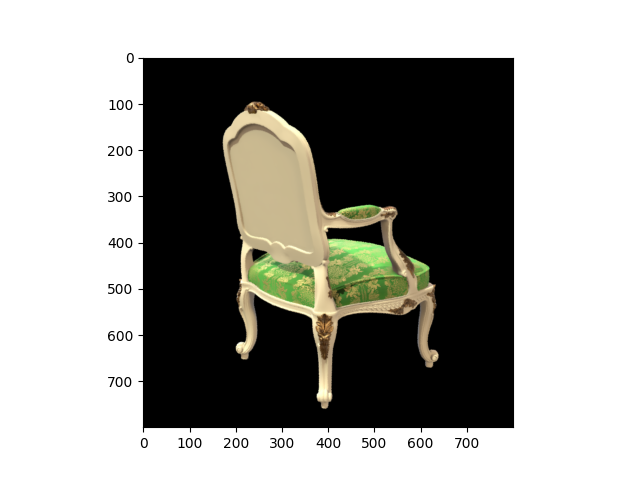

In [43]:

viewpoint_stack = content_scene.getTrainCameras().copy()

viewpoint_cam = viewpoint_stack[15]

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)


image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

In [163]:

def obtain_surface_pc(viewpoint_stack, gaussians, pipe, background, num_viewpoints=40, pc_size=20000):
    import numpy as np
    import skimage.measure, skimage.morphology
    import scipy

    # 1. Render from different viewpoints and extract points
    all_points = []
    for iter in range(min(num_viewpoints, len(viewpoint_stack))):
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        render_pkg_cont = render(viewpoint_cam, gaussians, pipe, background)
        image = render_pkg_cont["render"]
        image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
        image_maxpool = skimage.measure.block_reduce(image_rgb, (3,3,1), np.max)
        mask = scipy.ndimage.binary_erosion(np.max(image_maxpool, axis=-1) > 0.01, structure=None, iterations=3)
        image_clean = image_maxpool * np.expand_dims(mask, axis=-1)
        all_points += list(image_clean[np.min(image_clean, axis=-1)>0.01])
    
    
    # 2. Subsample the points 
    all_points = np.array(all_points)
    all_points_idcs = np.random.choice(range(len(all_points)), size=pc_size, replace=False) 
    all_points = all_points[all_points_idcs]

    # 3. Remove poitns that are too far away from all other points.
    # Compute all pairwise distances between points
    from scipy.spatial import distance
    k=10
    pairwise_distances = distance.cdist(all_points, all_points, 'euclidean')
    # Use np.partition to find the k-th smallest distances for each row
    kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
    kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
    q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.99)
    idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
    all_points = all_points[idcs]
    return all_points


def masks_to_points(masks, image_coords_as_rgb):
    """
    Retrieve for each mask points belonging to this mask from the image_coords_as_rgb image. 
    """
    import numpy as np
    import skimage.measure, skimage.morphology
    import scipy
    
    masks_points = []
    for mask in masks:
        image_rgb = np.expand_dims(mask, axis=-1) * image_coords_as_rgb
        image_maxpool = skimage.measure.block_reduce(image_rgb, (3,3,1), np.max)
        mask_erosion = scipy.ndimage.binary_erosion(np.max(image_maxpool, axis=-1) > 0.02, structure=None, iterations=1)
        image_clean = image_maxpool * np.expand_dims(mask_erosion, axis=-1)
        masks_points.append(np.array(image_clean[np.min(image_clean, axis=-1)>0.02]))

    return masks_points
  


def process_new_masks(masks, masks_points, target_points_coords, target_points_lbls):
    """
    For each mask for each point we find a point in target_point_coords that is the closest and check its 
    label in the target_points_lbls. Now if one label has at least 50% of the points. Then we consider this label to be found
    and we can assign the same label to the rest of the points target_points_coords that have been retrieved 
    for a current mask. Mask also receives this label. 
    :param masks: are just 2d masks
    :param masks_points: 3d points corresponding to those masks
    
    :param target_points_coords:  contain coordinatates the mesh of the scene with some points labels.
    :param target_points_lbls: array of the same length that the target_points_coords has but every element 
        indicates the label this point has. If no label assigned yet - the label will be -1.
    Masks are regular 2d masks 
    """
    masks_lbls_new = []
    masks_points_lbls = []
    target_points_coords = torch.tensor(target_points_coords, dtype=torch.float32)
    target_points_lbls = torch.tensor(target_points_lbls, dtype=torch.int32)
    for mask, mask_points in zip(masks, masks_points):
        #if np.mean(mask) < 0.01: 
        #    continue
        D = torch.cdist(torch.tensor(mask_points), target_points_coords)
        nn_idx = torch.argmin(D, dim=1)
        masks_lbls =  target_points_lbls[nn_idx]
        masks_lbls_vals, masks_lbls_freq = torch.unique(masks_lbls, sorted=True, return_inverse=False, return_counts=True, dim=None)
        print(masks_lbls_vals,masks_lbls_freq)
        masks_lbls_freq = masks_lbls_freq / torch.sum(masks_lbls_freq)
        print(masks_lbls_freq)

        if len(masks_lbls_freq)==0: continue
        most_freq_idx = np.argmax(masks_lbls_freq)
        if masks_lbls_freq[most_freq_idx]> 0.75 and masks_lbls_vals[most_freq_idx]!=-1:
            # if the labels has large overlap with existing mask and if this existing mask
            # is not unknown (-1)
            masks_lbls_new.append( int(masks_lbls_vals[most_freq_idx].detach().cpu().numpy()))
        else:
            masks_lbls_new.append(-1)
    return masks_lbls_new


        
def assign_initial_lbls(masks_points, masks_lbls, target_points_coords, target_points_lbls):
    """
    For each mask and each point in a mask find the nearest point  in target_points_coords 
    and assign to this target point the label from the masks_lbls list.
    :param masks_points: list of N elements with various number of points inside in each element 
    :param masks_lbls: list of N integer labels for each mask
    :param: array of size [M,3] of target points.
    :param: array of size [M] of integers containing labels of each target point.
    """

    for mask_points, mask_lbl in zip(masks_points, masks_lbls):
        D = torch.cdist(torch.tensor(mask_points), target_points_coords)
        nn_idx = torch.argmin(D, dim=1)
        # Only assign values if initial value is -1
        target_points_lbls[nn_idx] = target_points_lbls[nn_idx] + (target_points_lbls[nn_idx]==(-1)).to(torch.int32) * (1+mask_lbl)
        

    


def process_scene():
    # 1. Get target points representing the mesh
    # 2. Process scene from all the viewpoints available, compute SAM masks and points on the mesh for every mask.
    # 3. Assign initial labels by manually selecting the masks I consider important.
    # 4. Compute distances between all the available scenes.
    # 5. Now iterate over all the views. Find the view nearest to one of the existing views and expand our points
    #    assignments with this novel view.
    # 6. Assign a label to all the remaining points based on the label of the nearest labeled neighbor.
    # 7. Finally, assign labels to every SAM mask we have for all the viewpoints. Also merge or delete masks that are 
    #    not fitting to the labeled mesh points.
    #

    kth_viewpoint = 5


    # 1. Get target points representing the mesh
    content_gaussians._opacity.data +=  1e6
    content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
    content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
    content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.
    
    content_surface_pc = obtain_surface_pc(viewpoint_stack=viewpoint_stack, 
                                   gaussians=content_gaussians, 
                                   pipe=pipe, 
                                   background=background,
                                   num_viewpoints=40)
    
    content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs/GT_hotdog/chkpnt30000.pth")[0], opt)



    # 2. Process scene from all the viewpoints available, compute SAM masks and points on the mesh for every mask.
    viewpoint_stack = content_scene.getTrainCameras().copy()
    bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device=device)
    results = {}
    for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):
        viewpoint_cam = viewpoint_stack[viewpoint_cam_idx]
        render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
        image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
        image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)

        # Apply SAM to get masks.
        sam_result = mask_generator.generate(np.clip(image_rgb*255., 0., 255.).astype(np.uint8))
        masks = [
            mask['segmentation']
            for mask
            in sorted(sam_result, key=lambda x: x['area'], reverse=False)
        ]
        
        detections = sv.Detections.from_sam(sam_result=sam_result)
        image_bgr = (np.array(image_rgb[...,[2,1,0]])*255.).astype(np.uint8)
        annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    
        results[viewpoint_cam_idx] = {"viewpoint_cam" : viewpoint_cam,
                                      "image_rgb" : image_rgb,
                                      "image_bgr" : image_bgr,
                                      "masks" : masks,
                                      "detections" : detections,
                                      "annotated_image" : annotated_image}
    # 2.1 For each viewpoint extract images in format coords_as_rgb. 
    # Meaning that the RGB color represents the coordinate of the point
    content_gaussians._opacity.data +=  1e6
    content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
    content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
    content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.
    
    
    for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):
    
        
        viewpoint_cam = viewpoint_stack[viewpoint_cam_idx]
        
        bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device=device)
        render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
        image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
        image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
        
        
        image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
        results[viewpoint_cam_idx]["image_coords_as_rgb"] = image_rgb
    
    
    # Restore original gaussians parameters
    content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs/GT_hotdog/chkpnt30000.pth")[0], opt)

        
                                      
    # 2.2 Add masks_to_points fields to the results dictionary. Those assign 3D points to every mask we have.
    for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):
        masks_points = masks_to_points(results[viewpoint_cam_idx]["masks"], 
                                       image_coords_as_rgb=results[viewpoint_cam_idx]["image_coords_as_rgb"])
        results[viewpoint_cam_idx]["masks_points"] = masks_points

    # 3. Assign initial labels by manually selecting the masks you deem useful.    
    content_surface_pc_lbls = torch.ones(len(content_surface_pc), dtype=torch.int32)*-1
    # For viewpoint_cam = 0
    relevant_masks_idcs = [-2,-9,-10,-11,-12,-13,-14,-15,-16]
    relevant_masks_idcs = [x % len(results[0]["masks"]) for x in relevant_masks_idcs]
    assign_initial_lbls(masks_points=[results[0]["masks_points"][i] for i in relevant_masks_idcs], 
                        masks_lbls=relevant_masks_idcs, 
                        target_points_coords=torch.tensor(content_surface_pc), 
                        target_points_lbls=content_surface_pc_lbls)
        

    # 4. Compute distances between all the available scenes.
    # all_fpt = torch.stack([results[key]["viewpoint_cam"].full_proj_transform for key in results.keys()], axis=0)
    # this version using camera center is somewhat more robust, however for some scenes it can be bad.
    all_fpt = torch.stack([results[key]["viewpoint_cam"].camera_center for key in results.keys()], axis=0)
    all_fpt_D = torch.cdist(all_fpt.reshape(len(viewpoint_stack), -1), all_fpt.reshape(len(viewpoint_stack), -1))

    # 5.
   
    
        
    masks_lbls = process_new_masks(masks=results[idx]["masks"],
                      masks_points=results[idx]["masks_points"],
                      target_points_coords=content_surface_pc,
                      target_points_lbls=content_surface_pc_lbls)
    

    

In [132]:
kth_viewpoint = 5
# 1. Get target points representing the mesh
content_gaussians._opacity.data +=  1e6
content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.

content_surface_pc = obtain_surface_pc(viewpoint_stack=viewpoint_stack, 
                               gaussians=content_gaussians, 
                               pipe=pipe, 
                               background=background,
                               num_viewpoints=40)

content_gaussians.restore(torch.load(PATH_TO_CKPT)[0], opt)




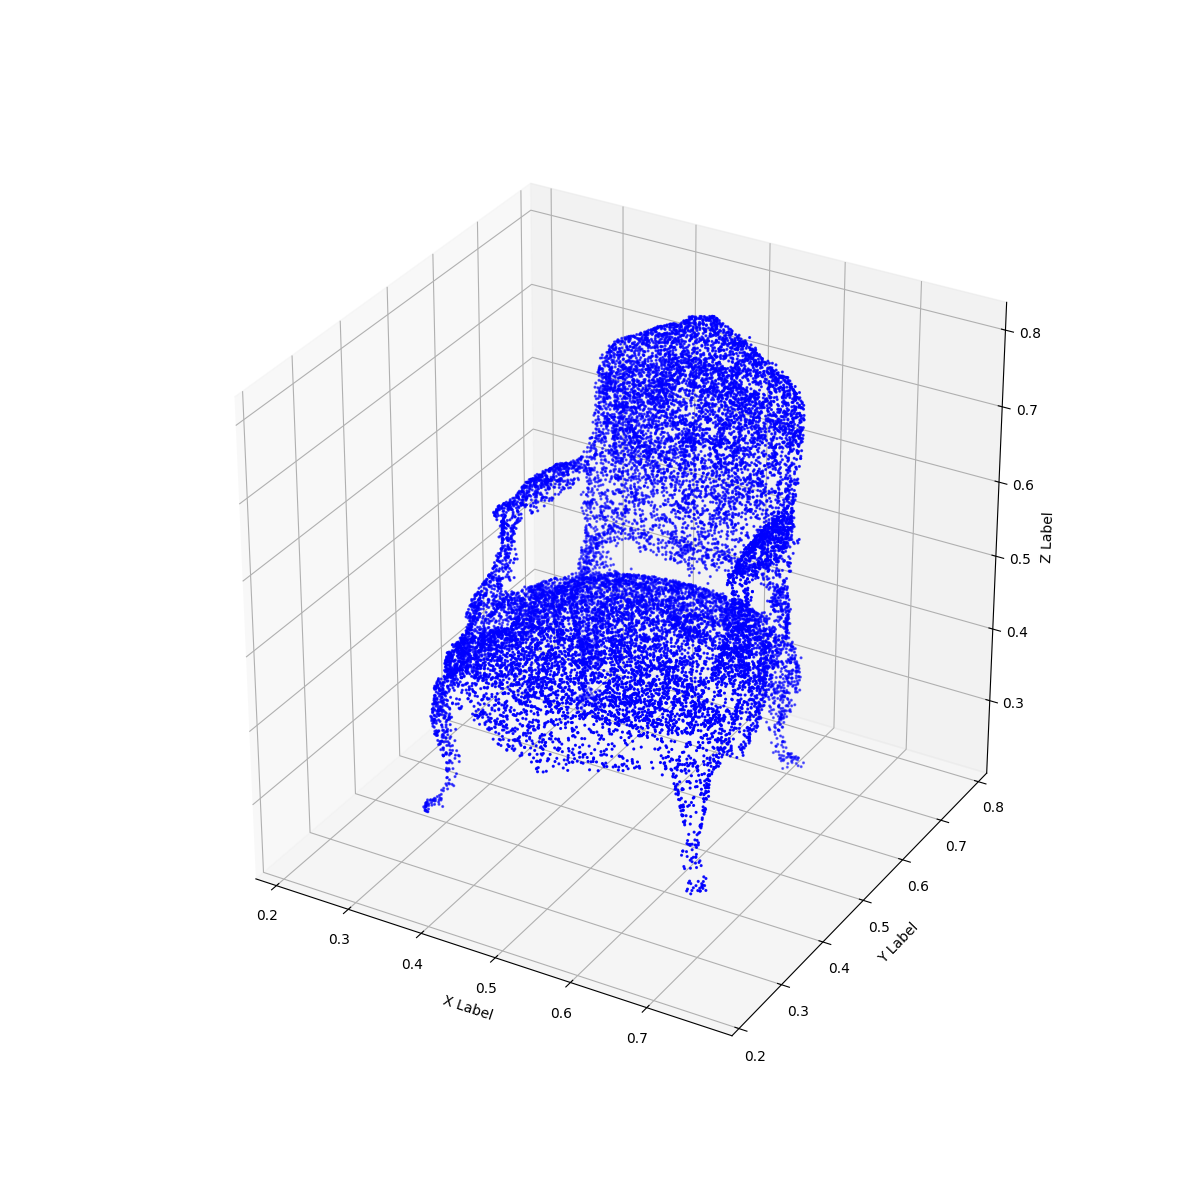

In [133]:


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr = content_surface_pc
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], 
               c='b', marker='o',s=1.5)


# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()


In [44]:

# 2. Process scene from all the viewpoints available, compute SAM masks and points on the mesh for every mask.
viewpoint_stack = content_scene.getTrainCameras().copy()
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
results = {}
for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):
    viewpoint_cam = viewpoint_stack[viewpoint_cam_idx]
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
    image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)

    # Apply SAM to get masks.
    sam_result = mask_generator.generate(np.clip(image_rgb*255., 0., 255.).astype(np.uint8))
    masks = [
        mask['segmentation']
        for mask
        in sorted(sam_result, key=lambda x: x['area'], reverse=False)
    ]
    
    detections = sv.Detections.from_sam(sam_result=sam_result)
    image_bgr = (np.array(image_rgb[...,[2,1,0]])*255.).astype(np.uint8)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    results[viewpoint_cam_idx] = {"viewpoint_cam" : viewpoint_cam,
                                  "image_rgb" : image_rgb,
                                  "image_bgr" : image_bgr,
                                  "masks" : masks,
                                  "detections" : detections,
                                  "annotated_image" : annotated_image}


/tmp/ipykernel_1770497/3906631509.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):


  0%|          | 0/60 [00:00<?, ?it/s]

In [45]:
# For each viewpoint extract images in format coords_as_rgb. 
# Meaning that the RGB color represents the coordinate of the point
content_gaussians._opacity.data +=  1e6
content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.


for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):

    
    viewpoint_cam = viewpoint_stack[viewpoint_cam_idx]
    
    bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device=device)
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
    image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
    
    
    image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
    results[viewpoint_cam_idx]["image_coords_as_rgb"] = image_rgb


# Restore original gaussians parameters
content_gaussians.restore(torch.load(PATH_TO_CKPT)[0], opt)


/tmp/ipykernel_1770497/4057511154.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):


  0%|          | 0/60 [00:00<?, ?it/s]

In [134]:
# 2.1 Add masks_to_points fields to the results dictionary. Those assign 3D points to every mask we have.
for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):
    masks_points = masks_to_points(results[viewpoint_cam_idx]["masks"], 
                                   image_coords_as_rgb=results[viewpoint_cam_idx]["image_coords_as_rgb"])
    results[viewpoint_cam_idx]["masks_points"] = masks_points

/tmp/ipykernel_1770497/2844390660.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for viewpoint_cam_idx in tqdm(range(0, len(viewpoint_stack), kth_viewpoint)):


  0%|          | 0/44 [00:00<?, ?it/s]

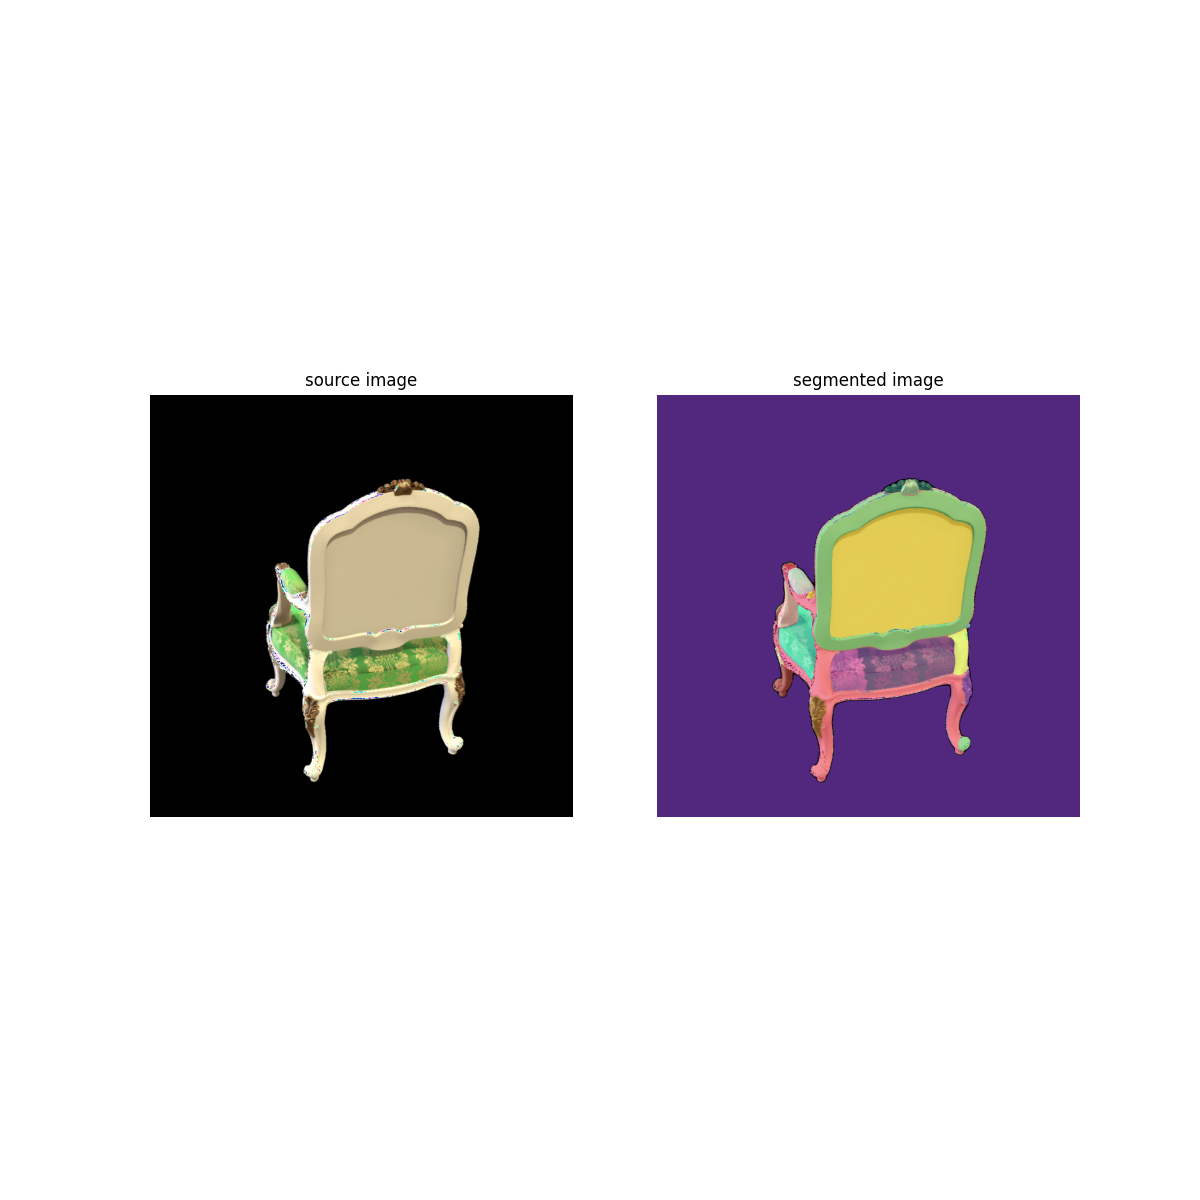

5


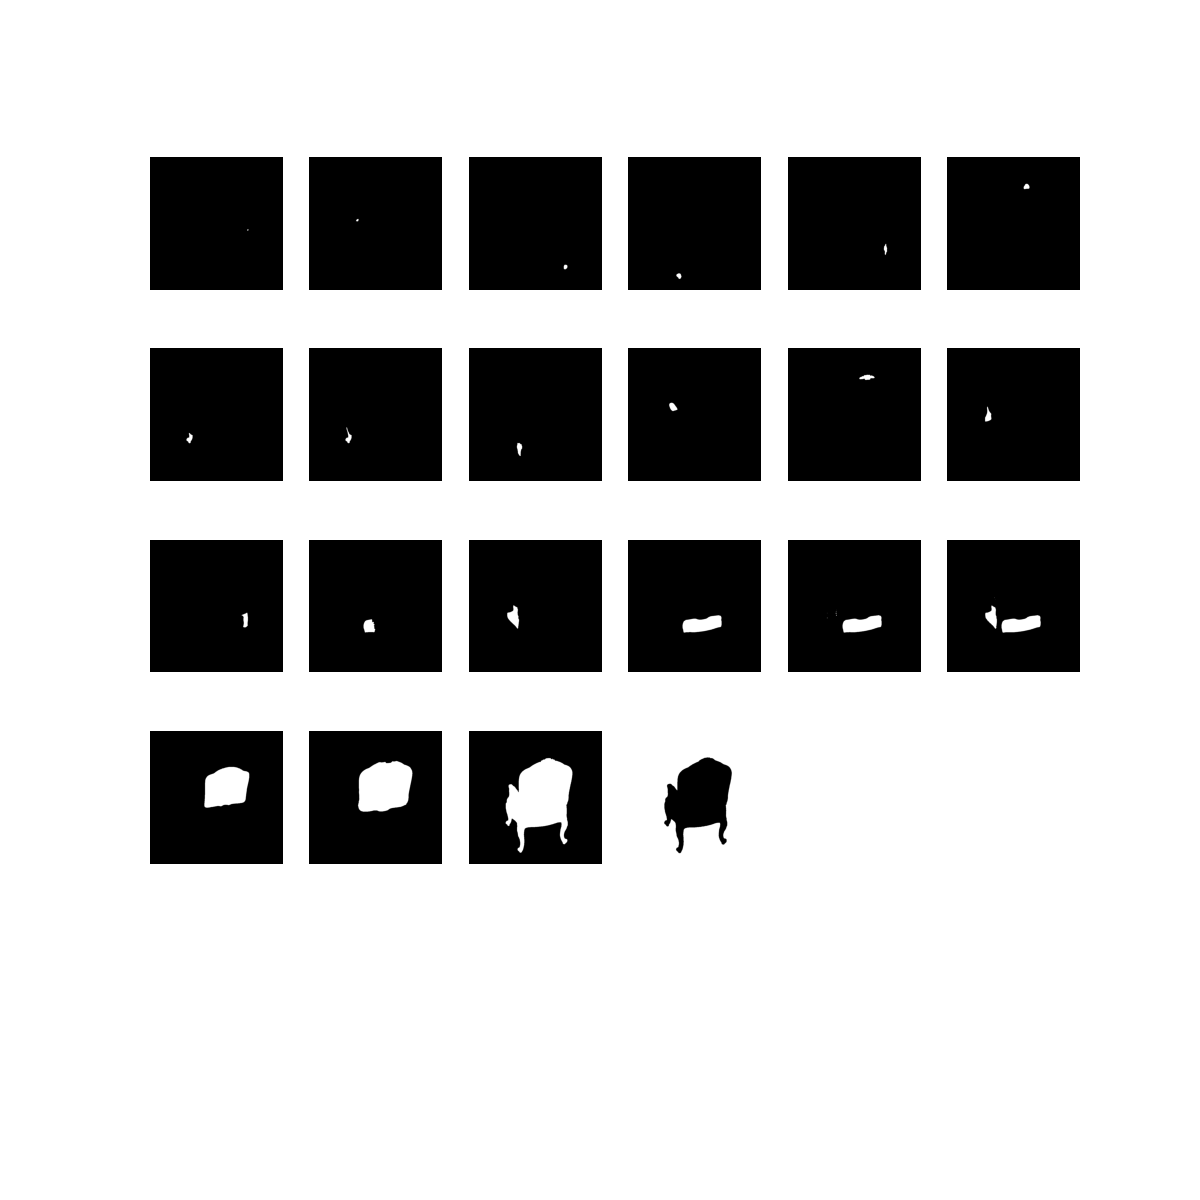

In [225]:
viewpoint_cam_idx = 65 # 35 #15
sv.plot_images_grid(
    images=[results[viewpoint_cam_idx]["image_bgr"], results[viewpoint_cam_idx]["annotated_image"]],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


q = int(np.sqrt(len(results[viewpoint_cam_idx]["masks"]))) + 1
print(q)
sv.plot_images_grid(
    images=results[viewpoint_cam_idx]["masks"],
    grid_size=(q,q+1),
    size=(12, 12)
)

In [194]:
relevant_masks_idcs

[29, 28, 27, 26]

/tmp/ipykernel_1770497/3424962414.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][mask_idx]*(2**idx) for idx, mask_idx in enumerate([-2,-3,-4,-6]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


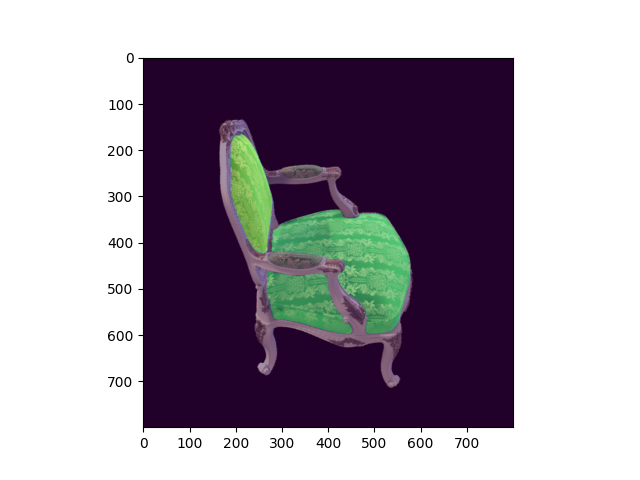

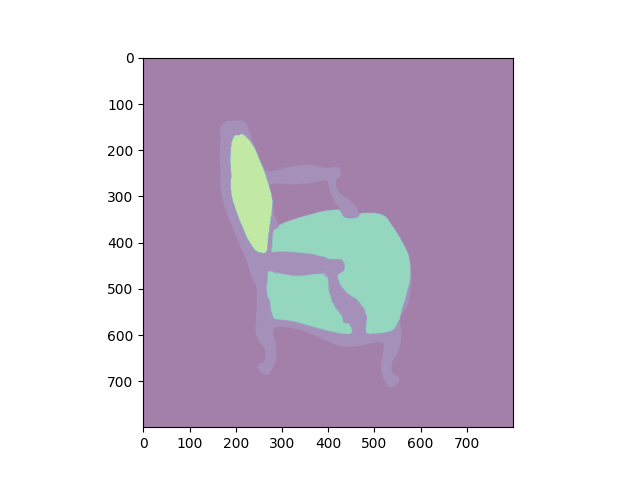

In [195]:
summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][mask_idx]*(2**idx) for idx, mask_idx in enumerate([-2,-3,-4,-6]))
plt.figure()
plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()

plt.figure()
#plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()

In [196]:
lbls_surrogate, lbls_surrogate_count = np.unique(summed_masks,return_counts=True)
masks_surrogate = [summed_masks==lbl for lbl in np.unique(summed_masks)]

# remove zeros and remove those classes that are almost absent
idcs_to_leave = np.where(lbls_surrogate_count > 20*20)[0]
idcs_to_leave = [idx for idx in idcs_to_leave if lbls_surrogate[idx]!=0]

masks_surrogate=[masks_surrogate[idx] for idx in np.array(idcs_to_leave)]
lbls_surrogate=[lbls_surrogate[idx] for idx in np.array(idcs_to_leave)]


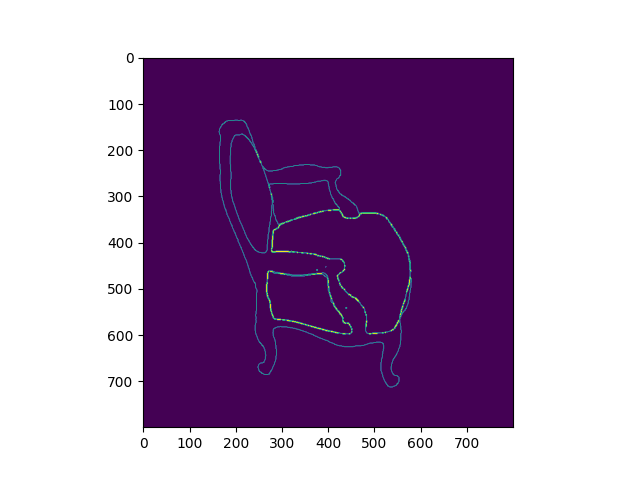

In [218]:
edged = None
for mask in masks_surrogate:
    
    mask = np.array(mask).astype(np.uint8)*255
    if edged is not None:
        edged = edged + cv2.Canny(mask, 30, 200) 
    else:
        edged = cv2.Canny(mask, 30, 200) 
        
plt.figure()
plt.imshow(edged>0)
plt.show()

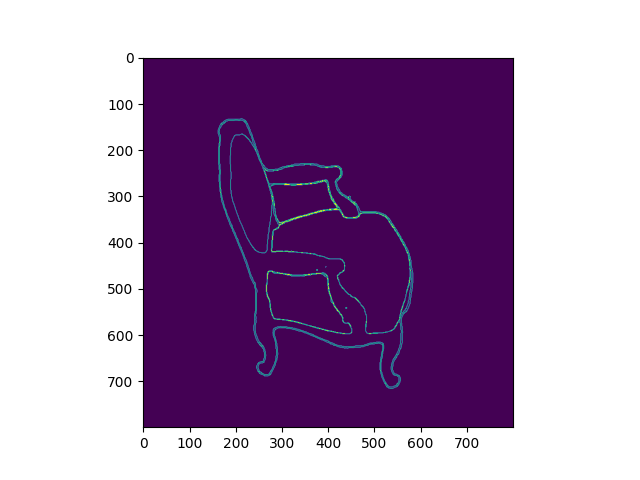

In [220]:
edged = None
for mask in results[viewpoint_cam_idx]["masks"]:
    if np.mean(mask) < 0.01: continue
    mask = np.array(mask).astype(np.uint8)*255
    if edged is not None:
        edged = edged + cv2.Canny(mask, 30, 200) 
    else:
        edged = cv2.Canny(mask, 30, 200) 
        
plt.figure()
plt.imshow(edged>0)
plt.show()

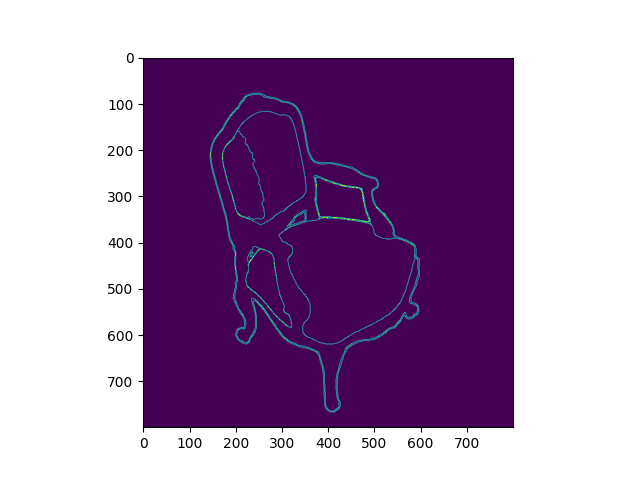

In [222]:
edged = None
for mask in results[viewpoint_cam_idx]["masks"]:
    if np.mean(mask) < 0.01: continue
    mask = np.array(mask).astype(np.uint8)*255
    if edged is not None:
        edged = edged + cv2.Canny(mask, 30, 200) 
    else:
        edged = cv2.Canny(mask, 30, 200) 
        
plt.figure()
plt.imshow(edged>0)
plt.show()

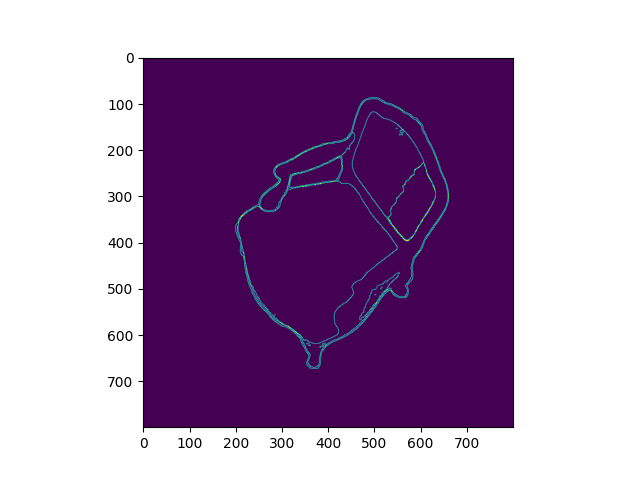

In [224]:
edged = None
for mask in results[viewpoint_cam_idx]["masks"]:
    if np.mean(mask) < 0.01: continue
    mask = np.array(mask).astype(np.uint8)*255
    if edged is not None:
        edged = edged + cv2.Canny(mask, 30, 200) 
    else:
        edged = cv2.Canny(mask, 30, 200) 
        
plt.figure()
plt.imshow(edged>0)
plt.show()

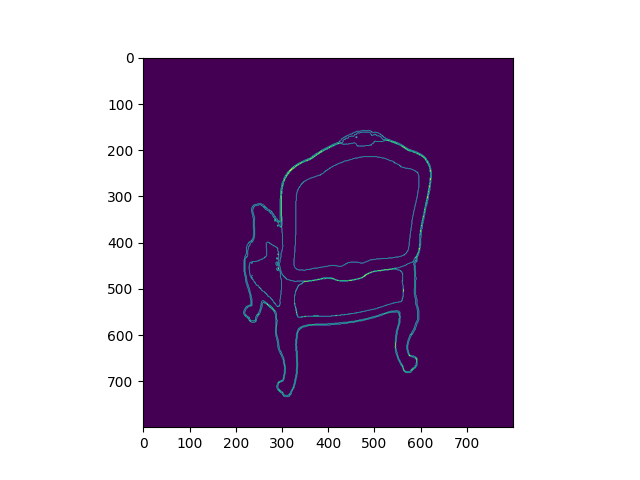

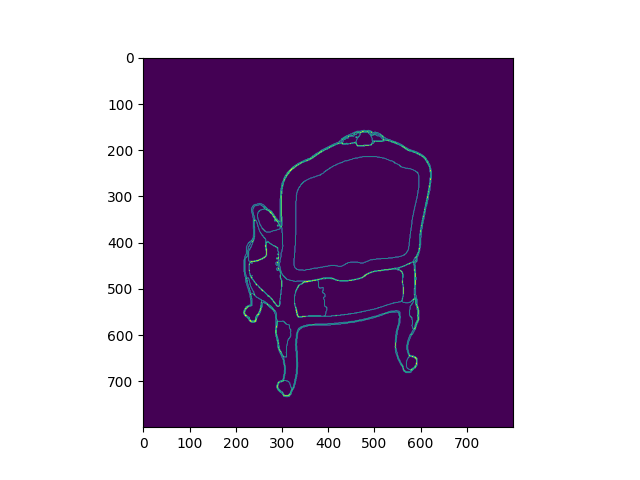

In [230]:
edged = None
for mask in results[viewpoint_cam_idx]["masks"]:
    if np.mean(mask) < 0.01: continue
    mask = np.array(mask).astype(np.uint8)*255
    if edged is not None:
        edged = edged + cv2.Canny(mask, 30, 200) 
    else:
        edged = cv2.Canny(mask, 30, 200) 
        
plt.figure()
plt.imshow(edged>0)
plt.show()

edged = None
for mask in results[viewpoint_cam_idx]["masks"]:
    if np.mean(mask) < 0.0005: continue
    mask = np.array(mask).astype(np.uint8)*255
    if edged is not None:
        edged = edged + cv2.Canny(mask, 30, 200) 
    else:
        edged = cv2.Canny(mask, 30, 200) 
        
plt.figure()
plt.imshow(edged>0)
plt.show()

In [213]:
import cv2
mask = np.array(masks_surrogate[0]).astype(np.uint8)*255
ret,thresh = cv2.threshold(mask,127,255,0)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
tmp = np.zeros_like(mask)
#tmp = np.zeros_like(im)
boundary = cv2.drawContours(tmp, contours, 0,1, 1)

#contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA
#boundary[boundary > 0] = 255

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - Layout of the output array image is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'image'


In [211]:
tmp[contours]=1

IndexError: too many indices for array: array is 2-dimensional, but 31 were indexed

In [205]:
contours

(array([[[577, 444]]], dtype=int32),
 array([[[572, 423]]], dtype=int32),
 array([[[560, 399]]], dtype=int32),
 array([[[552, 385]]], dtype=int32),
 array([[[539, 365]],
 
        [[540, 366]]], dtype=int32),
 array([[[537, 362]]], dtype=int32),
 array([[[297, 361]]], dtype=int32),
 array([[[299, 360]]], dtype=int32),
 array([[[301, 359]],
 
        [[302, 359]]], dtype=int32),
 array([[[527, 348]],
 
        [[528, 349]]], dtype=int32),
 array([[[332, 348]]], dtype=int32),
 array([[[335, 347]]], dtype=int32),
 array([[[338, 346]]], dtype=int32),
 array([[[346, 344]]], dtype=int32),
 array([[[503, 337]],
 
        [[504, 337]]], dtype=int32),
 array([[[473, 337]]], dtype=int32),
 array([[[371, 337]]], dtype=int32),
 array([[[382, 334]],
 
        [[383, 334]]], dtype=int32),
 array([[[388, 333]]], dtype=int32),
 array([[[401, 331]]], dtype=int32),
 array([[[411, 330]],
 
        [[412, 330]],
 
        [[413, 330]],
 
        [[412, 330]]], dtype=int32),
 array([[[277, 296]]], dtype=in

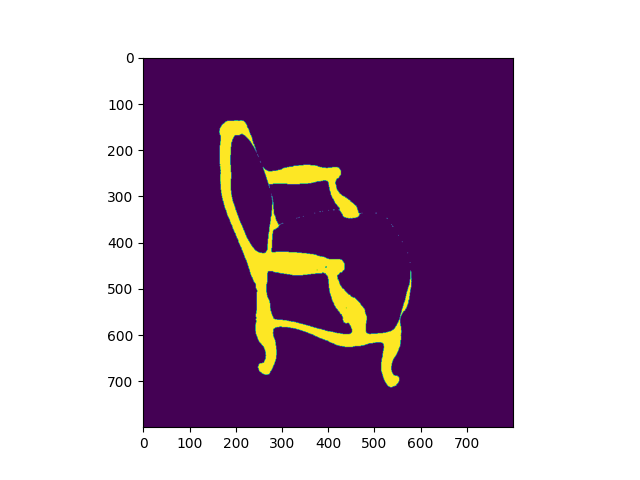

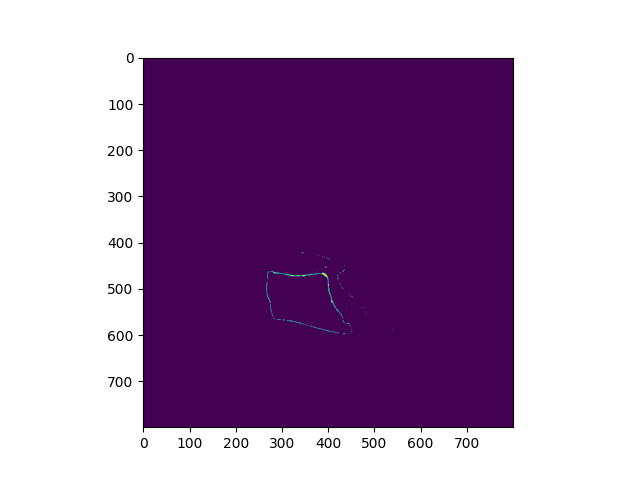

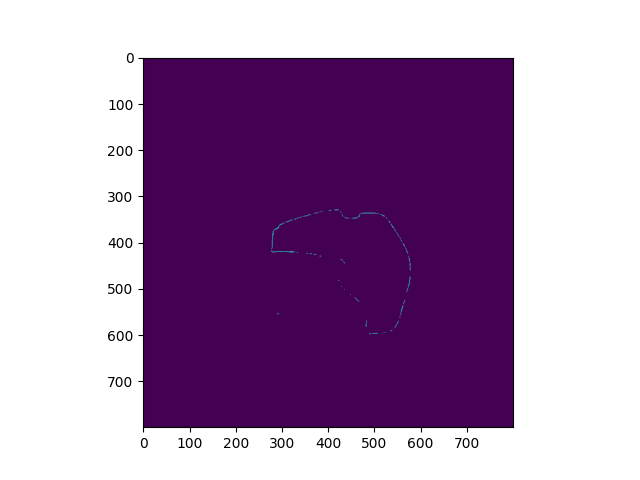

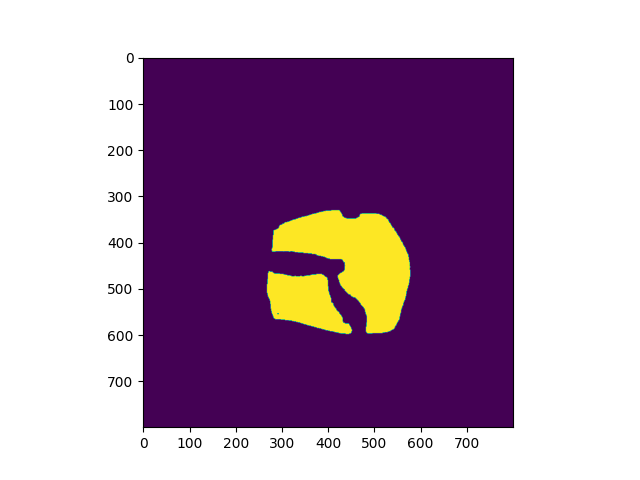

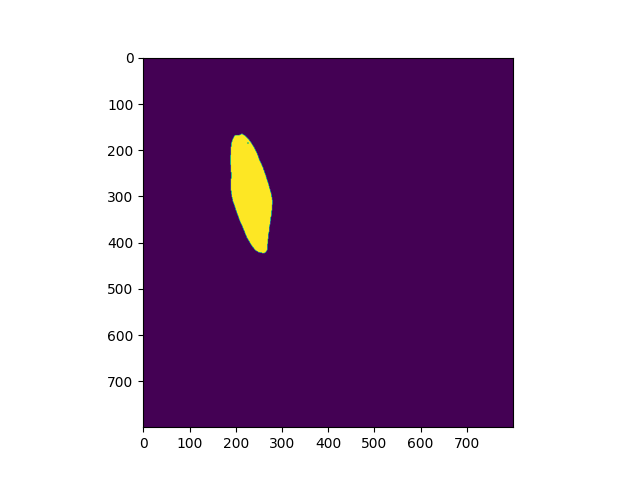

In [198]:
for mask in masks_surrogate:
    plt.figure()
    plt.imshow(mask)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


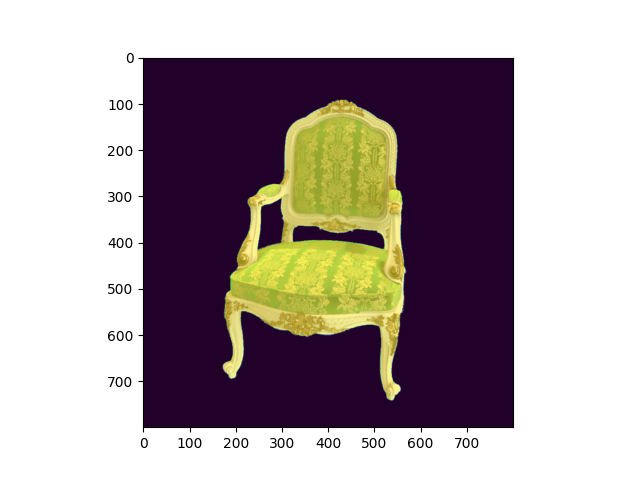

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


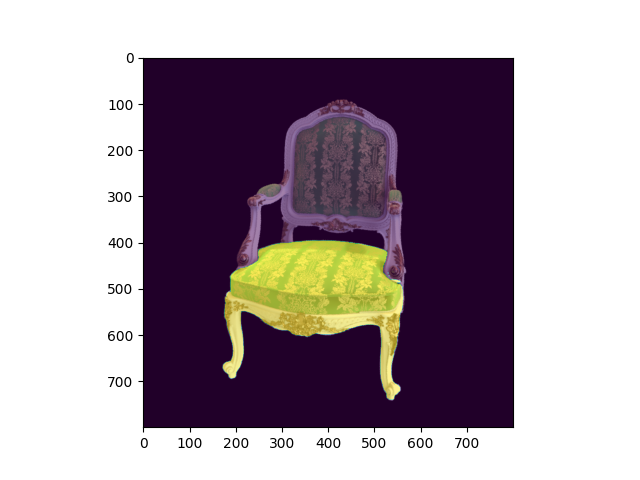

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


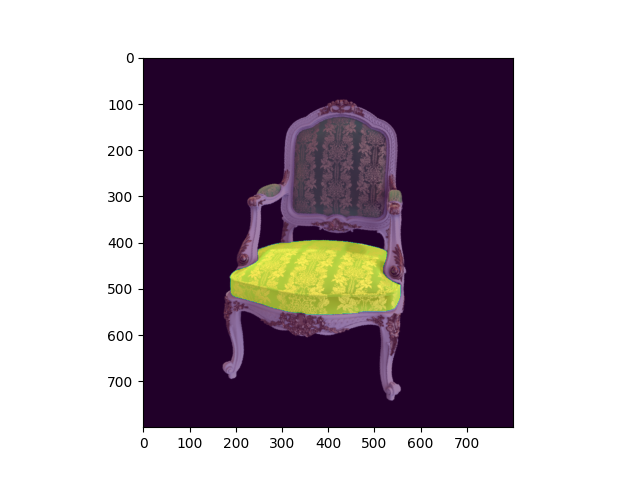

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


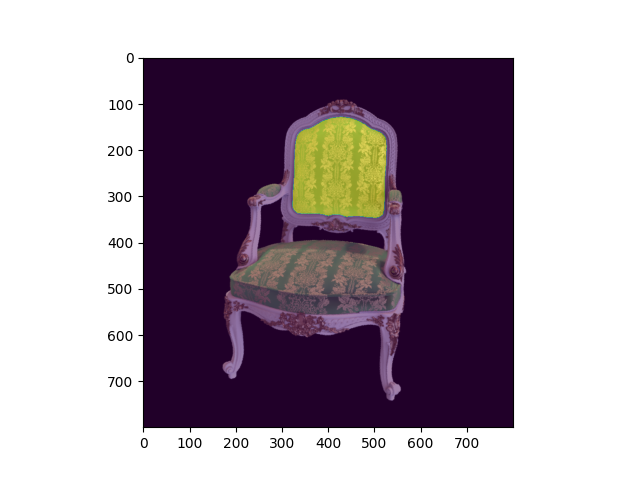

In [139]:
#relevant_masks_idcs = [-2,-9,-10,-11,-12,-13,-14,-15,-16]
relevant_masks_idcs = [-2,-8,-9, -10,-11,-12,-13,-14,-15]
relevant_masks_idcs = [-2,-7, -8,-9, -10,-11,-12,-13,-14]
# now for chair
relevant_masks_idcs = [-2, -3, -4, -5]


relevant_masks_idcs = [x % len(results[viewpoint_cam_idx]["masks"]) for x in relevant_masks_idcs]

for idx in relevant_masks_idcs:
    # plt.figure()
    # plt.imshow(results[0]["masks"][idx])
    # plt.show()

    plt.figure()
    #plt.title(f"{lbl}")
    plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
    plt.imshow(results[viewpoint_cam_idx]["masks"][idx], alpha=0.5)
    plt.show()

/tmp/ipykernel_1770497/1353878319.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][mask_idx]*(2**idx) for idx, mask_idx in enumerate(relevant_masks_idcs))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


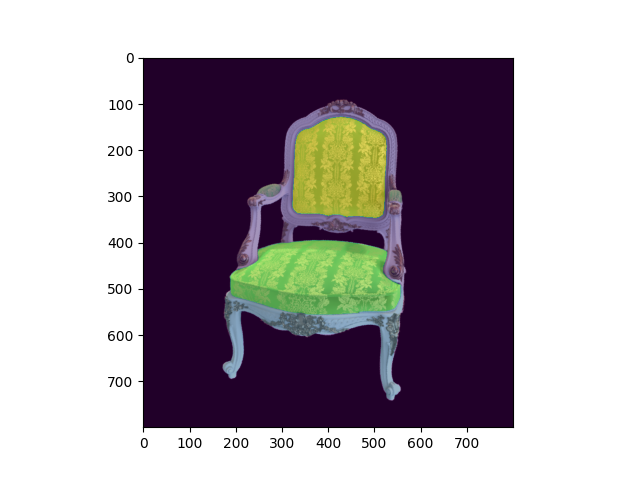

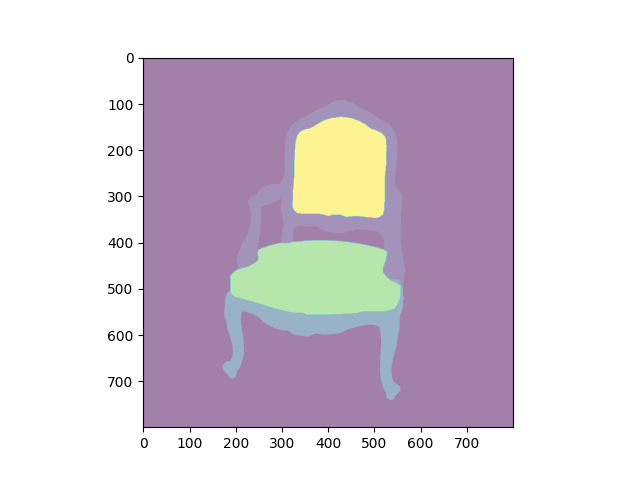

In [140]:
summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][mask_idx]*(2**idx) for idx, mask_idx in enumerate(relevant_masks_idcs))
plt.figure()
plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()

plt.figure()
#plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()

In [141]:
lbls_surrogate, lbls_surrogate_count = np.unique(summed_masks,return_counts=True)
masks_surrogate = [summed_masks==lbl for lbl in np.unique(summed_masks)]

# remove zeros and remove those classes that are almost absent
idcs_to_leave = np.where(lbls_surrogate_count > 20*20)[0]
idcs_to_leave = [idx for idx in idcs_to_leave if lbls_surrogate[idx]!=0]

masks_surrogate=[masks_surrogate[idx] for idx in np.array(idcs_to_leave)]
lbls_surrogate=[lbls_surrogate[idx] for idx in np.array(idcs_to_leave)]

masks_points_surrogate = masks_to_points(masks_surrogate, 
                                         image_coords_as_rgb=results[viewpoint_cam_idx]["image_coords_as_rgb"])

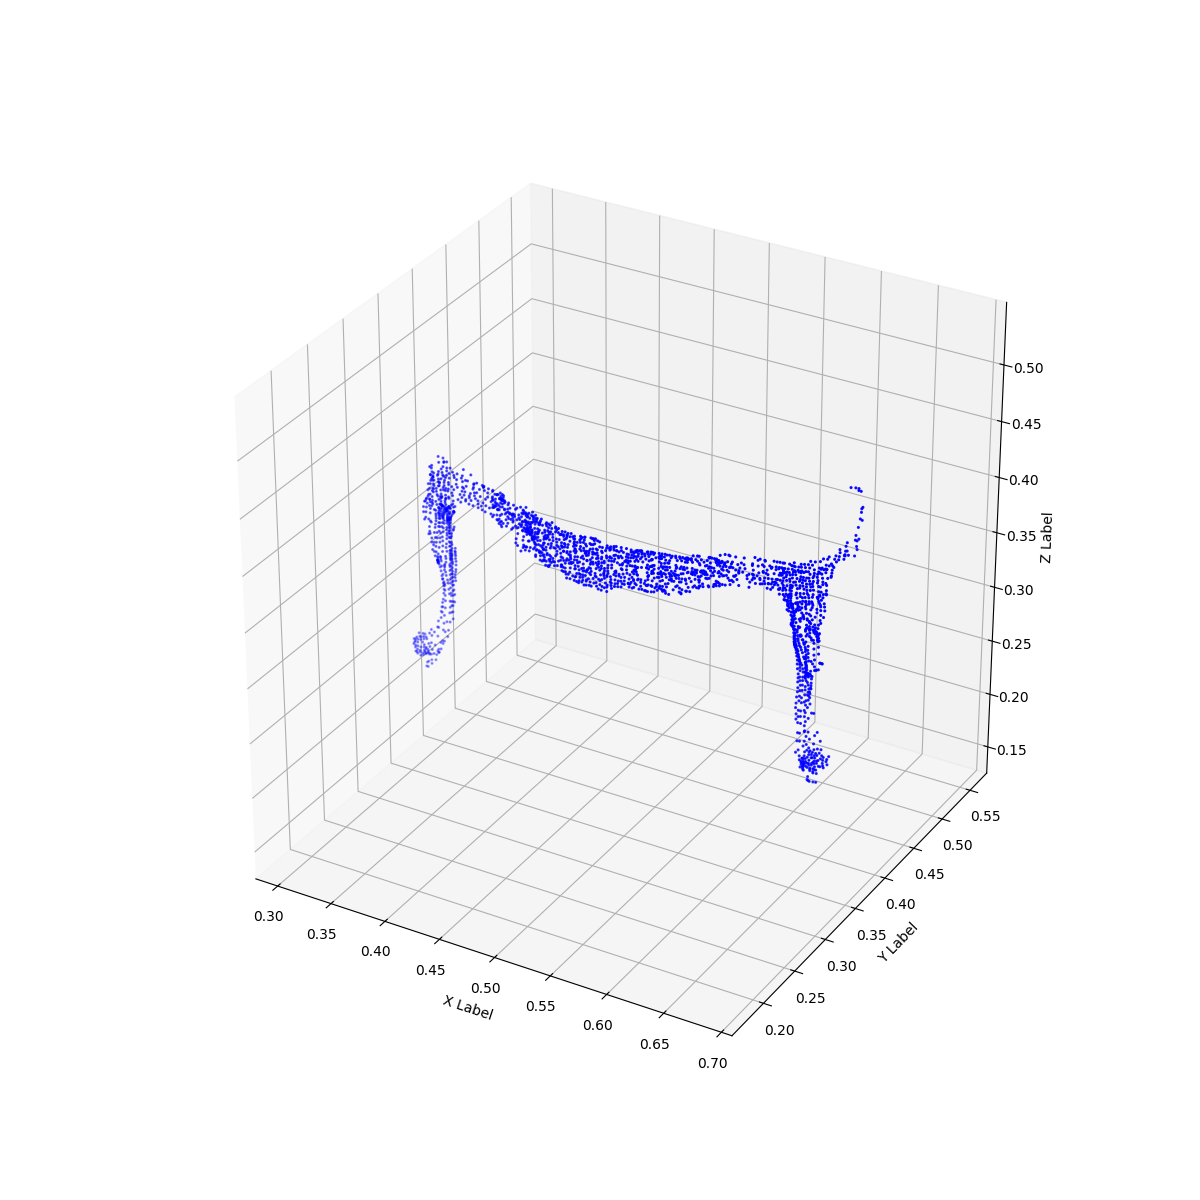

In [148]:


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr = masks_points_surrogate[1]
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], 
               c='b', marker='o',s=1.5)


# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()


In [149]:
relevant_masks_idcs

[29, 28, 27, 26]

In [164]:
content_surface_pc_lbls = torch.ones(len(content_surface_pc), dtype=torch.int32)*-1
assign_initial_lbls(masks_points=masks_points_surrogate, 
                    masks_lbls=lbls_surrogate, 
                    target_points_coords=torch.tensor(content_surface_pc), 
                    target_points_lbls=content_surface_pc_lbls)

In [17]:
# content_surface_pc_lbls = torch.ones(len(content_surface_pc), dtype=torch.int32)*-1
# assign_initial_lbls(masks_points=[results[0]["masks_points"][i] for i in relevant_masks_idcs], 
#                     masks_lbls=relevant_masks_idcs, 
#                     target_points_coords=torch.tensor(content_surface_pc), 
#                     target_points_lbls=content_surface_pc_lbls)

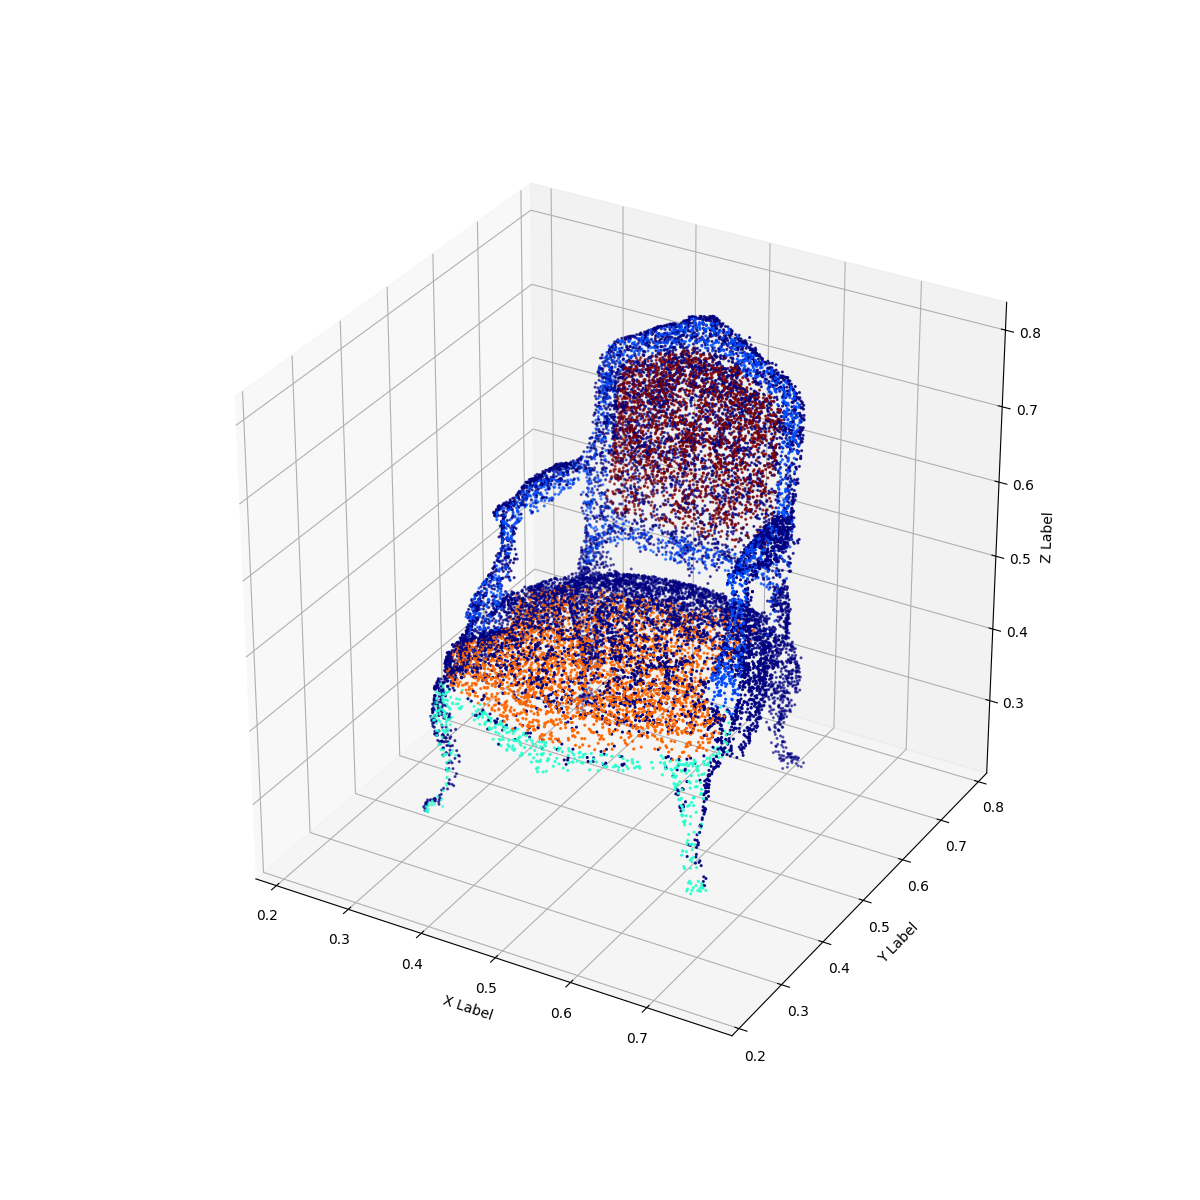

In [165]:
integer_labels = content_surface_pc_lbls.detach().cpu().numpy()
# Normalize integer labels to [0, 1] for colormap mapping
normalized_labels = (integer_labels - np.min(integer_labels)) / (np.max(integer_labels) - np.min(integer_labels))

# Create a colormap suitable for diverging values
cmap = plt.cm.prism
# cmap = plt.cm.nipy_spectral
cmap = plt.cm.jet

# Map the normalized labels to colors in the colormap
colors = cmap(normalized_labels)




fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr = content_surface_pc
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], 
               c=colors, marker='o',s=1.5)


# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()


In [168]:

# 4. Compute distances between all the available scenes.
all_fpt = torch.stack([results[key]["viewpoint_cam"].camera_center for key in results.keys()], axis=0)
all_fpt_D = torch.cdist(all_fpt.reshape(len(results.keys()), -1), all_fpt.reshape(len(results.keys()), -1))




dict_key_to_idx = {key:idx for idx,key in enumerate(results.keys())}
# Add initial key for labels.
processed_keys = [viewpoint_cam_idx]
unprocessed_keys = list(results.keys())
unprocessed_keys = [x for x in unprocessed_keys if x not in processed_keys]

num_steps = 0
for i in tqdm(range(len(unprocessed_keys))):
    num_steps += 1
    all_fpt_D_processed_to_unprocessed = all_fpt_D[[dict_key_to_idx[x] for x in processed_keys]][:, [dict_key_to_idx[x] for x in unprocessed_keys]]
    new_idx = int((all_fpt_D_processed_to_unprocessed==torch.min(all_fpt_D_processed_to_unprocessed)).nonzero()[0][1])
    new_key = unprocessed_keys[new_idx]



    
    
    # sv.plot_images_grid(
    #     images=[results[new_key]["image_bgr"], results[new_key]["annotated_image"]],
    #     grid_size=(1, 2),
    #     titles=['source image', 'segmented image']
    # )
    # q = int(np.sqrt(len(results[new_key]["masks"]))) + 1
    # print(q)
    # sv.plot_images_grid(
    #     images=results[new_key]["masks"],
    #     grid_size=(q,q+1),
    #     size=(12, 12)
    # )
    




    
    # Process new mask with this new key.
    masks_lbls_new_key = process_new_masks(masks=results[new_key]["masks"],
                          masks_points=results[new_key]["masks_points"],
                          target_points_coords=content_surface_pc,
                          target_points_lbls=content_surface_pc_lbls)
    # Use these newly computed labels and assign them to the image.
    # first, take only masks with actual values. In other words, ignore -1 label
    print(masks_lbls_new_key )
    relevant_indcs_masks_new_key = [i for i in range(len(masks_lbls_new_key)) if masks_lbls_new_key[i]!=-1]
    print(relevant_indcs_masks_new_key)
    print([masks_lbls_new_key[i] for i in relevant_indcs_masks_new_key])
    
    assign_initial_lbls(masks_points=[results[new_key]["masks_points"][i] for i in relevant_indcs_masks_new_key], 
                        masks_lbls=[masks_lbls_new_key[i] for i in relevant_indcs_masks_new_key], 
                        target_points_coords=torch.tensor(content_surface_pc), 
                        target_points_lbls=content_surface_pc_lbls)
    processed_keys.append(new_key)
    unprocessed_keys = [key for key in unprocessed_keys if key not in processed_keys]
    if num_steps > 10: break

/tmp/ipykernel_1770497/3522891429.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(unprocessed_keys))):


  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_1770497/2507635654.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_points_lbls = torch.tensor(target_points_lbls, dtype=torch.int32)


tensor([1], dtype=torch.int32) tensor([28])
tensor([1.])
tensor([1], dtype=torch.int32) tensor([26])
tensor([1.])
tensor([1], dtype=torch.int32) tensor([34])
tensor([1.])
tensor([3], dtype=torch.int32) tensor([35])
tensor([1.])
tensor([3], dtype=torch.int32) tensor([37])
tensor([1.])
tensor([1, 7], dtype=torch.int32) tensor([37,  1])
tensor([0.9737, 0.0263])
tensor([1], dtype=torch.int32) tensor([62])
tensor([1.])
tensor([1], dtype=torch.int32) tensor([67])
tensor([1.])
tensor([7], dtype=torch.int32) tensor([68])
tensor([1.])
tensor([3], dtype=torch.int32) tensor([78])
tensor([1.])
tensor([-1,  1,  9], dtype=torch.int32) tensor([33, 46, 18])
tensor([0.3402, 0.4742, 0.1856])
tensor([7], dtype=torch.int32) tensor([105])
tensor([1.])
tensor([1], dtype=torch.int32) tensor([117])
tensor([1.])
tensor([1], dtype=torch.int32) tensor([145])
tensor([1.])
tensor([7], dtype=torch.int32) tensor([159])
tensor([1.])
tensor([1], dtype=torch.int32) tensor([152])
tensor([1.])
tensor([3], dtype=torch.int

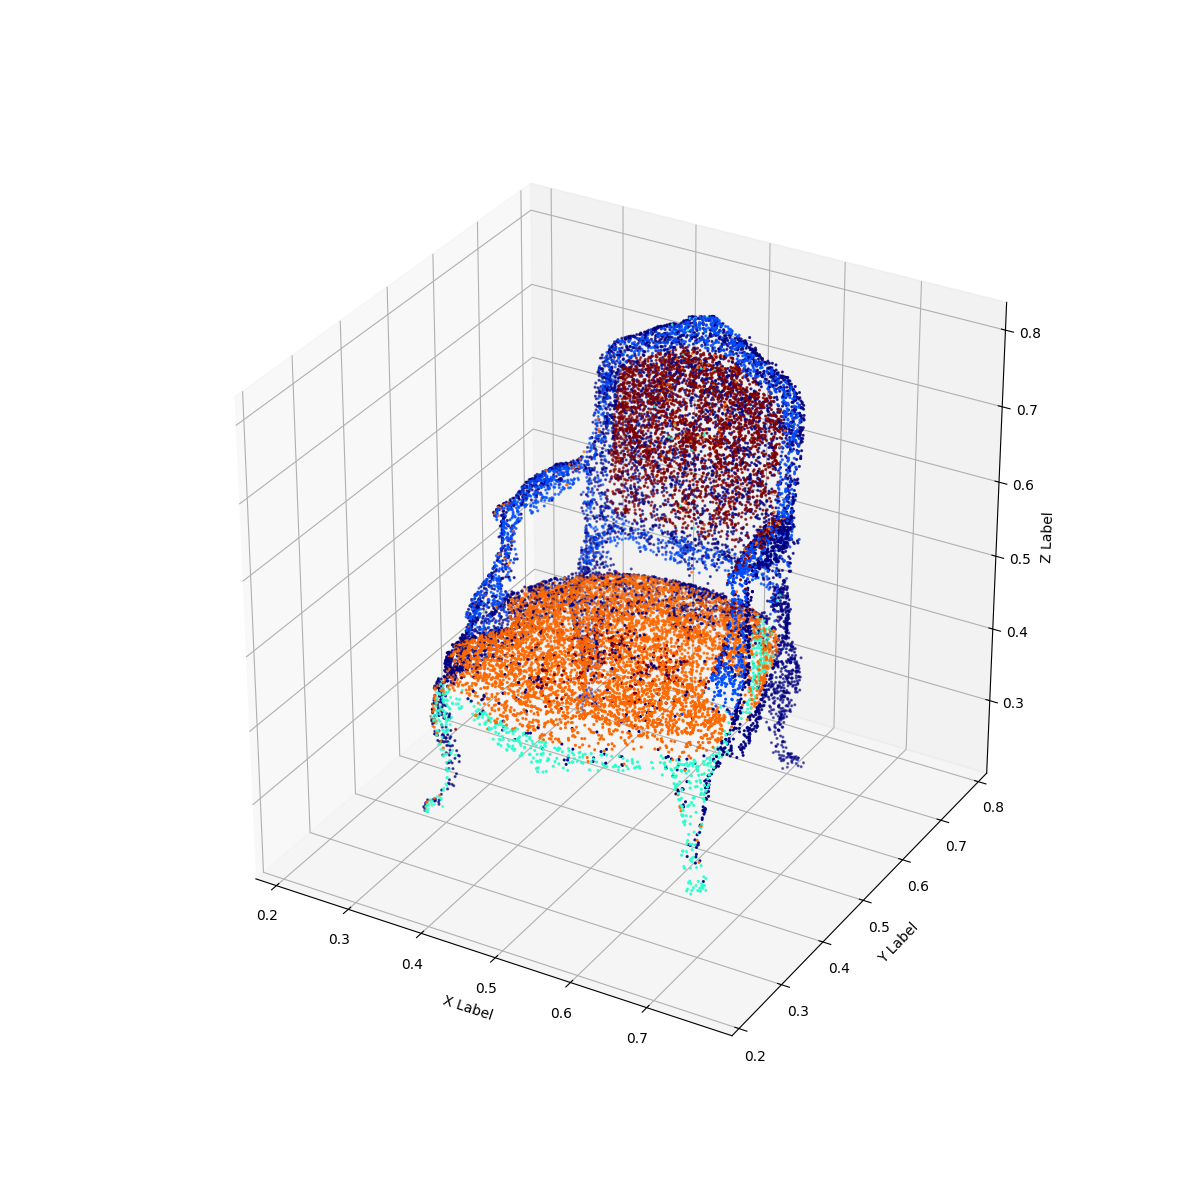

In [169]:
integer_labels = content_surface_pc_lbls.detach().cpu().numpy()
# Normalize integer labels to [0, 1] for colormap mapping
normalized_labels = (integer_labels - np.min(integer_labels)) / (np.max(integer_labels) - np.min(integer_labels))

# Create a colormap suitable for diverging values
cmap = plt.cm.prism
cmap = plt.cm.jet

# Map the normalized labels to colors in the colormap
colors = cmap(normalized_labels)




fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr = content_surface_pc
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], 
               c=colors, marker='o',s=1.5)


# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()


# Relabel masks we have precomputed

In [170]:
# 6. Assign labels to 2d masks for all masks in results dict{}
# for each viewpoint and each mask. Take its masks_points and find the nearest ones on the 
# content_surface_pc. Now if it has sufficient amount of points(NUM_points=50) and the most frequent class
# is larger then threshold (80%) we save this mask and corresponding most frequent label.
# also remove masks that are large in surface but have very few points. For that compute a relation of fraction of 
# points in the mask to the fraction of the occupied pixels in mask. This should be > 1.

thresh_mask_num_points = 500

thresh_mask_lbl_freq = 0.6
N = len(content_surface_pc)


for viewpoint_cam_idx in tqdm(results.keys()):
    results[viewpoint_cam_idx]["masks_clean"] = []
    results[viewpoint_cam_idx]["masks_clean_lbl"] = []
    for idx, mask in enumerate(results[viewpoint_cam_idx]["masks_points"]):
        nns_indcs = torch.argmin(torch.cdist(torch.tensor(mask), 
                                       torch.tensor(content_surface_pc)), dim=1)
        masks_lbls_vals, masks_lbls_freq = torch.unique(content_surface_pc_lbls[nns_indcs], sorted=True, return_inverse=False, return_counts=True, dim=None)
        masks_lbls_freq_relative = masks_lbls_freq / torch.sum(masks_lbls_freq)

        # Third criterion to remove masks that are almost empty (have no 3d points inside).
        frac_points = len(mask) / N
        frac_view = np.mean(results[viewpoint_cam_idx]["masks"][idx])
    
        if len(masks_lbls_freq) > 0 and (frac_points / (frac_view + 1e-6) > 1.):
            most_freq_idx = np.argmax(masks_lbls_freq)
            if (masks_lbls_freq[most_freq_idx] > thresh_mask_num_points) and \
                (masks_lbls_freq_relative[most_freq_idx] > thresh_mask_lbl_freq):
                results[viewpoint_cam_idx]["masks_clean"].append(results[viewpoint_cam_idx]["masks"][idx])
                results[viewpoint_cam_idx]["masks_clean_lbl"].append(int(masks_lbls_vals[most_freq_idx]))

        
        
        

# Now merge masks with the same label
for viewpoint_cam_idx in tqdm(results.keys()):
    new_masks_clean = []
    new_masks_clean_lbl = []
    for lbl in np.unique(results[viewpoint_cam_idx]["masks_clean_lbl"]):
        masks_for_lbl = [results[viewpoint_cam_idx]["masks_clean"][idx] 
                         for idx in np.where(results[viewpoint_cam_idx]["masks_clean_lbl"]==lbl)[0]]
        if len(masks_for_lbl) > 1:
            new_masks_clean.append(np.maximum.reduce(masks_for_lbl))
        else:
            new_masks_clean.append(masks_for_lbl[0])
            
    
    results[viewpoint_cam_idx]["masks_clean2"] = new_masks_clean
    results[viewpoint_cam_idx]["masks_clean_lbl2"] = np.unique(results[viewpoint_cam_idx]["masks_clean_lbl"])
    
    
    
    



/tmp/ipykernel_1770497/1475723944.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for viewpoint_cam_idx in tqdm(results.keys()):


  0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipykernel_1770497/1475723944.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for viewpoint_cam_idx in tqdm(results.keys()):


  0%|          | 0/60 [00:00<?, ?it/s]

In [171]:

# Now merge masks with the same label
for viewpoint_cam_idx in tqdm(results.keys()):
    new_masks_clean = []
    new_masks_clean_lbl = []
    for lbl in np.unique(results[viewpoint_cam_idx]["masks_clean_lbl"]):
        masks_for_lbl = [results[viewpoint_cam_idx]["masks_clean"][idx] 
                         for idx in np.where(results[viewpoint_cam_idx]["masks_clean_lbl"]==lbl)[0]]
        if len(masks_for_lbl) > 1:
            new_masks_clean.append(np.maximum.reduce(masks_for_lbl))
        else:
            new_masks_clean.append(masks_for_lbl[0])
            
    
    results[viewpoint_cam_idx]["masks_clean_merged"] = new_masks_clean
    results[viewpoint_cam_idx]["masks_clean_lbl_merged"] = np.unique(results[viewpoint_cam_idx]["masks_clean_lbl"])
    

/tmp/ipykernel_1770497/2791333148.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for viewpoint_cam_idx in tqdm(results.keys()):


  0%|          | 0/60 [00:00<?, ?it/s]

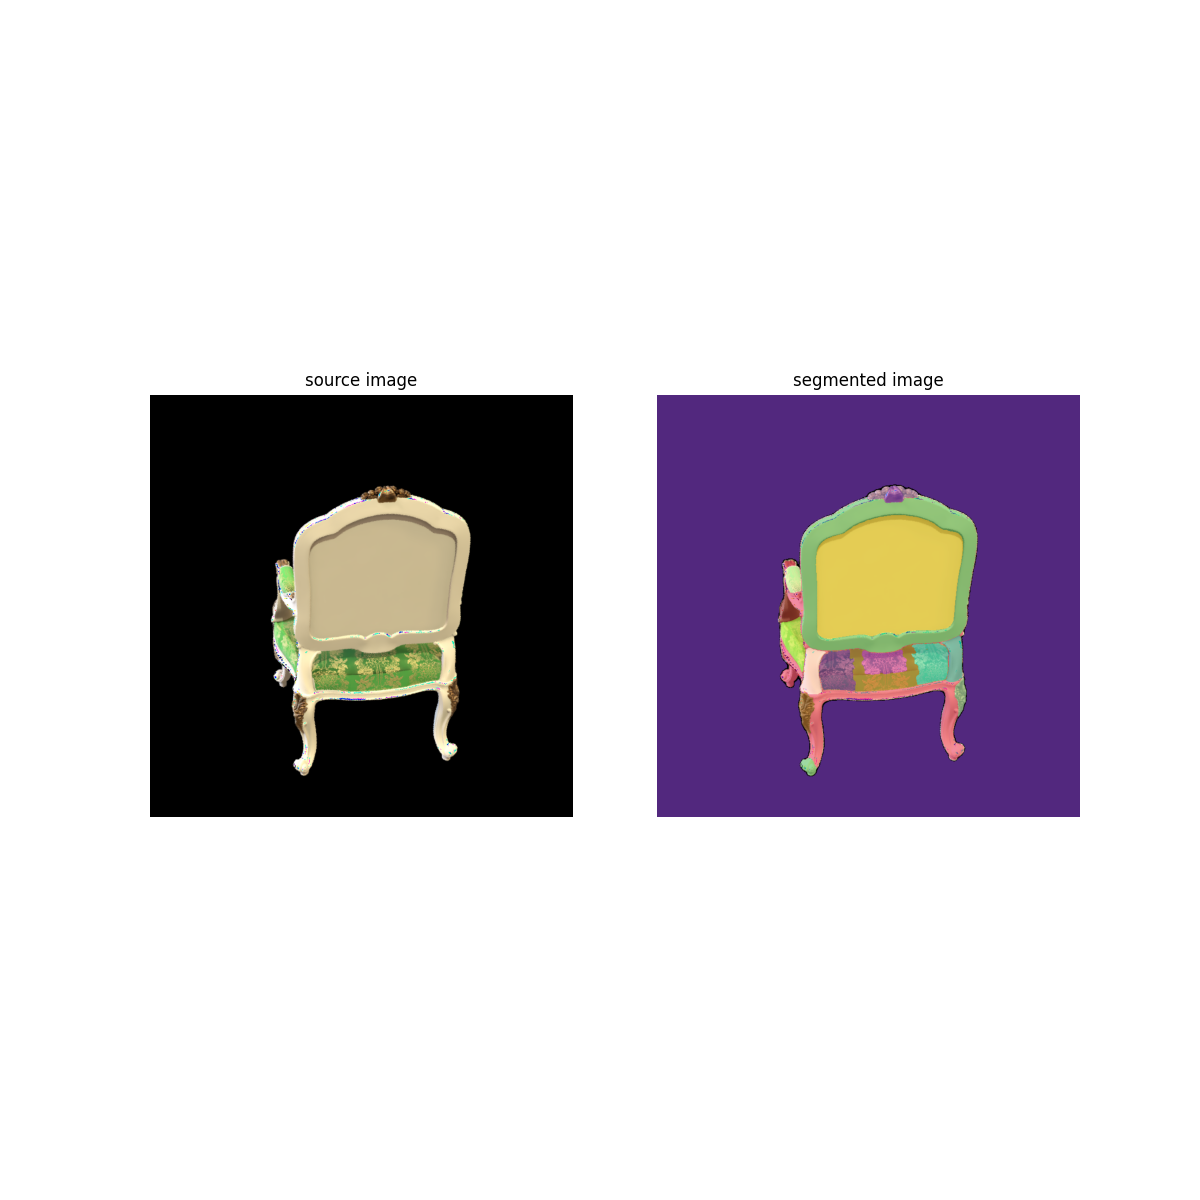

5


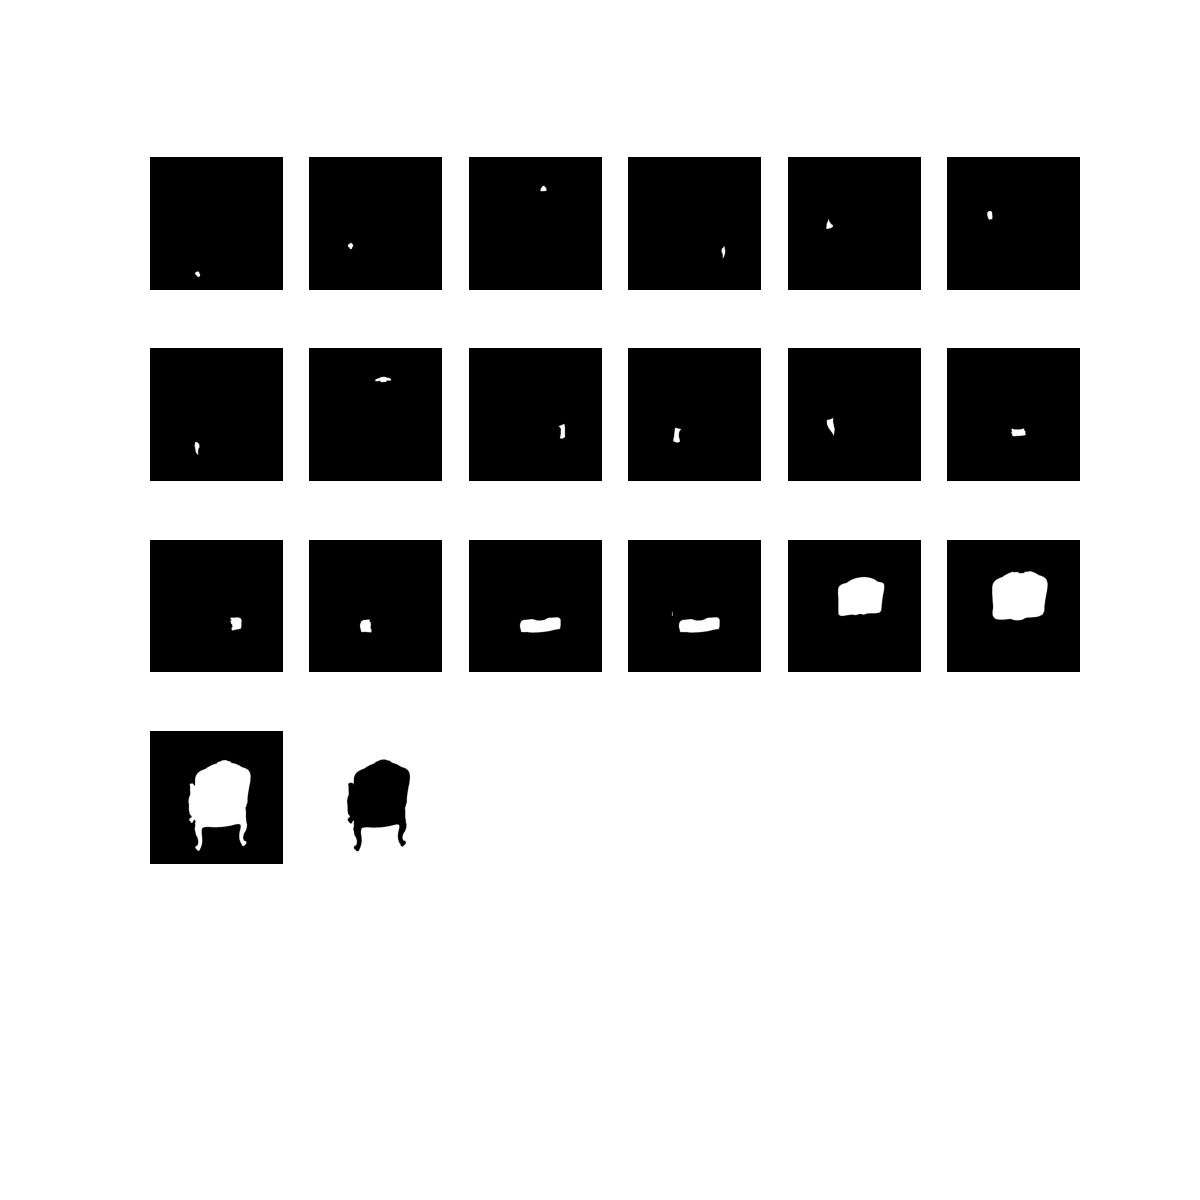

In [187]:

new_key = 40 #viewpoint_cam_idx
sv.plot_images_grid(
    images=[results[new_key]["image_bgr"], results[new_key]["annotated_image"]],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


q = int(np.sqrt(len(results[new_key]["masks"]))) + 1
print(q)
sv.plot_images_grid(
    images=results[new_key]["masks"],
    grid_size=(q,q+1),
    size=(12, 12)
)

In [188]:
N = len(content_surface_pc)
for mask_idx in range(len(results[new_key]["masks_points"])):
    frac_points = len(results[new_key]["masks_points"][mask_idx]) / N
    frac_view = np.mean(results[new_key]["masks"][mask_idx])
    print(mask_idx, len(results[new_key]["masks_points"][mask_idx]), np.mean(results[new_key]["masks"][mask_idx]),
          len(results[new_key]["masks_points"][mask_idx]) / N , np.mean(results[new_key]["masks"][mask_idx]),
          frac_points / frac_view)
    

0 61 0.001075 0.0030808080808080807 0.001075 2.865867982147052
1 73 0.00121875 0.0036868686868686868 0.00121875 3.0251230251230252
2 78 0.001365625 0.00393939393939394 0.001365625 2.884682060883434
3 79 0.00150625 0.00398989898989899 0.00150625 2.648895594953686
4 116 0.0020203125 0.005858585858585859 0.0020203125 2.8998414149226215
5 120 0.0020765625 0.006060606060606061 0.0020765625 2.9185762820074332
6 132 0.0022265625 0.006666666666666667 0.0022265625 2.994152046783626
7 187 0.003090625 0.009444444444444445 0.003090625 3.0558364228738344
8 207 0.0034796875 0.010454545454545454 0.0034796875 3.0044495244315628
9 256 0.0042078125 0.01292929292929293 0.0042078125 3.07268751383122
10 272 0.0044203125 0.013737373737373737 0.0044203125 3.1077833834991844
11 311 0.0050625 0.015707070707070708 0.0050625 3.1026312507793987
12 429 0.006690625 0.021666666666666667 0.006690625 3.2383621360734858
13 446 0.0069328125 0.022525252525252525 0.0069328125 3.2490785702415184
14 1866 0.027896875 0.09424

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(800, 800)


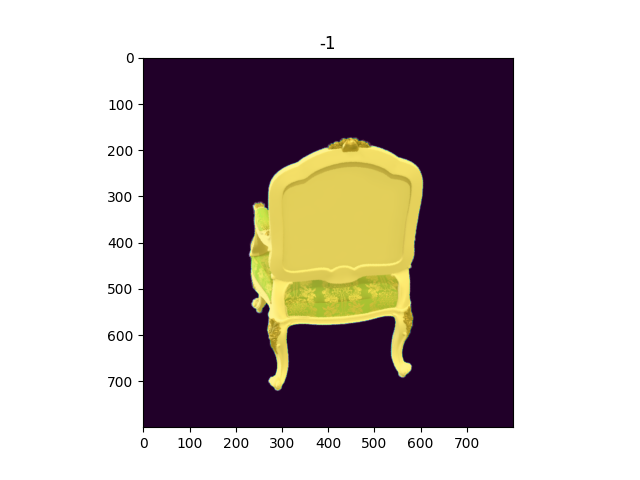

In [189]:

for mask, lbl in zip(results[new_key]["masks_clean_merged"], results[new_key]["masks_clean_lbl_merged"]):
    print(mask.shape)
    plt.figure()
    plt.title(f"{lbl}")
    plt.imshow(results[new_key]["image_rgb"])
    plt.imshow(mask, alpha=0.5)
    plt.show()
    

In [66]:
for key in results.keys():
    print(key, results[key]["masks_clean_lbl_merged"])

0 [ 3  4  5  6  7  8  9 10 15]
5 [ 4  5  6  7  8  9 10 15]
10 [ 4  7  8  9 15]
15 [15]
20 [ 5  9 10 15]
25 [ 3  4  5  7  8 15]
30 [ 4  5  6  7  8  9 10 15]
35 [ 5  6  8  9 10 15]
40 [ 5  6  7  8  9 10 15]
45 [ 4  5  6  7  8  9 10 15]
50 [ 5 15]
55 [ 4  5  6  7  8  9 10 15]
60 [ 3  4  5  6  8  9 10 15]
65 [ 5  6  7  8  9 10 15]
70 [ 4  5  6  7  8  9 10 15]
75 [ 3  4  8 15]
80 [ 5  9 10 15]
85 [ 4  5  6  8  9 15]
90 [ 4  5  6  7  8  9 10 15]
95 [ 5  6  8  9 10 15]
100 [ 4  5  6  7  8  9 10 15]
105 [ 4  5  6  7  8  9 10 15]
110 [ 4  6  7  8 10 15]
115 [ 3  4  7  8  9 10 15]
120 [ 3  4  6  7  8  9 15]
125 [ 3  4  8 10 15]
130 [ 3  4  7  8 15]
135 [ 3  4  5  7  8  9 15]
140 [ 3  4  5  6  7  8  9 10 15]
145 [ 4  5  6  7  8  9 10 15]
150 [ 5  6  7  8  9 10 15]
155 [ 5  6  7  8  9 10 15]
160 [ 5  6  8  9 10 15]
165 [ 5 10 15]
170 [ 5 10 15]
175 [ 5 10 15]
180 [ 5  9 15]
185 [ 5 15]
190 [ 5  8  9 15]
195 [ 5  8  9 15]
200 [ 6  8 15]
205 [15]
210 [15]
215 [15]
220 [15]
225 [15]
230 [15]
235 [15]

# Save dictionary with results

In [67]:
import pickle

# save dictionary to person_data.pkl file
with open('results_hotdog_SAM2.pkl', 'wb') as fp:
    pickle.dump(results, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [168]:
print("yo")

yo
